In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, pickle
from belief_tree import Tree

### Initialise the agent

In [2]:
def policy(q_values, temp=None, policy_type='softmax'):

    '''
    ----
    Agent's policy

    q_values -- q values at the current state
    temp     -- inverse temperature
    type     -- softmax / greeedy
    ----
    '''

    if np.all(q_values == 0):
        return np.array([0.5, 0.5])

    if temp:
        t = temp
    else:
        t = 1
        
    if policy_type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    elif policy_type == 'greedy':
        return np.array(q_values >= q_values.max()).astype(int)
    else:
        raise KeyError('Unknown policy type')

In [69]:
M = np.array([
    [16, 13],
    [3, 2]
])

gamma = 0.9
xi    = 0.0

Q = np.zeros(2)

tree = Tree(M, Q, 1, 'greedy')

### Full Bayesian updates

In [70]:
horizon = 3
tree.root_q_values = Q
tree.build_tree(horizon)
tree.full_updates(gamma)

In [71]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

array([1.59448276, 1.66137931])

### Replay

In [72]:
horizon = 4
tree.root_q_values = Q
tree.build_tree(horizon)
qval_history, need_history, replays = tree.replay_updates(gamma, xi)

In [73]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

array([0. , 0.6])

In [74]:
13/24

0.5416666666666666

### Generate replay tree

In [65]:
from tex_tree import generate_big_tex_tree

save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tree/example'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
    os.mkdir(save_folder)
else:
    os.makedirs(save_folder)

for idx, rep in enumerate(replays):
    these_replays = replays[:idx+1]
    save_path = os.path.join(save_folder, 'tex_tree_%u.tex'%idx)
    generate_big_tex_tree(horizon, these_replays, qval_history[idx], need_history[idx], save_path)

### Prior belief

In [66]:
from scipy.stats import beta

In [67]:
x = np.linspace(0.001, 1, 100)

a1b, b1b = M[0, :]
rv1b = beta(a1b, b1b)  

a1a, b1a = M[1, :]
rv1a = beta(a1a, b1a)

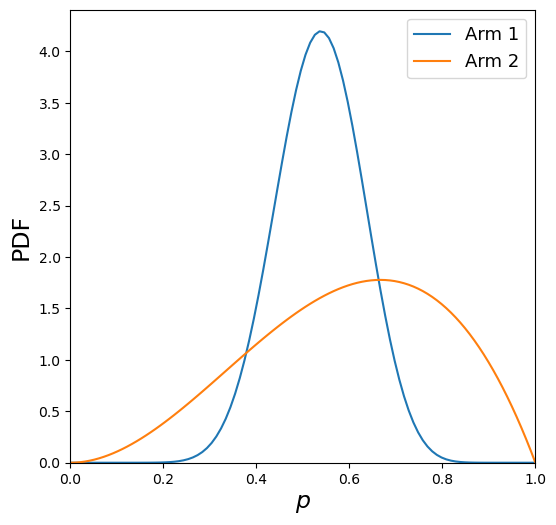

In [68]:
plt.figure(figsize=(6, 6), dpi=100)

plt.plot(x, rv1b.pdf(x), label='Arm 1')
plt.plot(x, rv1a.pdf(x), label='Arm 2')

plt.xlim(0, 1)
plt.ylim(0,)

plt.xlabel(r'$p$', fontsize=17)
plt.ylabel('PDF', fontsize=17)
plt.legend(prop={'size':13})
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/betas.png')

### Number of replays until convergence

In [ ]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tree/convergence'

# vary these parameters
alphas_0 = np.arange(1, 40)
betas_0  = np.arange(1, 40)

# constant parameters
alpha_1 = 1
beta_1  = 1

gamma   = 0.9
temp    = 1
xi      = 0.1

save_figures_path = os.path.join(save_folder, 'temp%u'%temp)
save_data_path    = os.path.join(save_folder, 'data', 'temp%u'%temp)

if not os.path.isdir(save_figures_path):
    os.makedirs(save_figures_path)
    os.makedirs(save_data_path)

for horizon in [3, 4, 5]:

    R_true = np.full((len(alphas_0), len(betas_0)), np.nan)
    R      = np.full((len(alphas_0), len(betas_0)), np.nan)
    N      = np.full((len(alphas_0), len(betas_0)), np.nan)

    for alpha_0 in alphas_0:
        for beta_0 in betas_0:
            
            # prior belie at the root
            M = np.array([
                [alpha_0, beta_0],
                [alpha_1, beta_1],
            ])

            # MF Q values at the root
            Q    = np.zeros(2)

            # initialise the agent
            tree = Tree(M, Q, temp, 'softmax')

            # build the tree
            tree.build_tree(horizon)
            
            # do full bayesian updates
            tree.full_updates(gamma)
            qval_tree = tree.qval_tree
            qvals     = qval_tree[0][(0, 0, 0)]
            print(r'$\alpha_0=%u, \beta_0=%u$'%(alpha_0, beta_0))
            v_full = np.max(qvals)
            
            # do replay
            tree.root_q_values = np.zeros(2)
            qval_history, need_history, replays = tree.replay_updates(gamma, xi)
            qval_tree = qval_history[-1]
            qvals     = qval_tree[0][(0, 0, 0)]
            v_replay  = np.dot(policy(qvals, temp=temp), qvals)

            R_true[alpha_0-alphas_0[0], beta_0-betas_0[0]] = v_full
            R[alpha_0-alphas_0[0], beta_0-betas_0[0]]      = v_replay
            N[alpha_0-alphas_0[0], beta_0-betas_0[0]]      = len(qval_history) - 1

    file_name = 'value_horizon%u_alpha%u_beta%u_xi%s_temp%u'%(horizon-1, alpha_1, beta_1, ''.join(str(xi).split('.')), temp)
    np.save(os.path.join(save_data_path, file_name + '.npy'), R)
    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    plt.pcolormesh(R, vmax=np.nanmax(R))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Root value', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)
    plt.savefig(os.path.join(save_figures_path, file_name + '.png'))
    plt.close()

    diff      = R_true - R
    file_name = 'value_diff_horizon%u_alpha%u_beta%u_xi%s_temp%u'%(horizon-1, alpha_1, beta_1, ''.join(str(xi).split('.')), temp)
    np.save(os.path.join(save_data_path, file_name + '.npy'), diff)
    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    plt.pcolormesh(diff, vmax=np.nanmax(diff))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('delta root value', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)
    plt.savefig(os.path.join(save_figures_path, file_name + '.png'))
    plt.close()

    file_name = 'num_horizon%u_alpha%u_beta%u_xi%s_temp%u'%(horizon-1, alpha_1, beta_1, ''.join(str(xi).split('.')), temp)
    np.save(os.path.join(save_data_path, file_name + '.npy'), N)
    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    plt.pcolormesh(N, vmax=np.nanmax(N))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Number of replays', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)
    plt.savefig(os.path.join(save_figures_path, file_name + '.png'))
    plt.close()

    print('Done with horizon %u'%horizon)

### Replay threshold and value convergence

In [21]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tree/convergence'

# vary these parameters
# xis       = np.append(0, np.logspace(np.log2(0.001), np.log2(1.0), 10, base=2))
xis       = np.logspace(np.log2(0.0001), np.log2(1.0), 11, base=2)
horizons  = [2, 3, 4, 5]
betas     = [1.5, 2, 4]

# constant parameters
alpha_0 = 14
beta_0  = 10
alpha_1 = 4
beta_1  = 3

gamma   = 0.9

# prior belie at the root
M = np.array([
    [alpha_0, beta_0],
    [alpha_1, beta_1],
], dtype=int)

# MF Q values at the root
Q    = np.zeros(2)

# store results here
P      = np.zeros((len(horizons), len(betas), len(xis)))
R      = np.zeros((len(horizons), len(betas), len(xis)))
nreps  = np.zeros((len(horizons), len(betas), len(xis)), dtype=int)
R_true = np.zeros(len(horizons))

for hidx, horizon in enumerate(horizons):
            
    # initialise the agent
    tree = Tree(M, Q, 1, 'softmax')
    tree.build_tree(horizon)
    
    # do full bayesian updates
    tree.full_updates(gamma)
    qval_tree    = tree.qval_tree
    qvals        = qval_tree[0][(0, 0, 0)]
    v_full       = np.max(qvals)
    R_true[hidx] = v_full
    
    for bidx, beta in enumerate(betas):

        # initialise the agent
        tree = Tree(M, Q, beta, 'softmax')

        for xidx, xi in enumerate(xis):

            tree.build_tree(horizon)
            # do replay
            qval_history, need_history, replays = tree.replay_updates(gamma, xi)
            qvals     = tree.qval_tree[0][(0, 0, 0)]
            v_replay  = np.dot(policy(qvals, temp=beta), qvals)

            eval_pol  = tree.evaluate_policy(tree.qval_tree)

            P[hidx, bidx, xidx]     = eval_pol
            R[hidx, bidx, xidx]     = v_replay
            nreps[hidx, bidx, xidx] = len(replays)-1

    print('Horizon %u'%horizon)

fig, axes = plt.subplots(6, 2, figsize=(9, 18), dpi=100, constrained_layout=True, gridspec_kw={'height_ratios':[2, 2, 1, 2, 2, 1]})
# plt.suptitle('alpha0 = %u, beta0 = %u, alpha1 = %u, beta1 = %u'%(alpha_0, beta_0, alpha_1, beta_1), fontsize=14)

for hidx, h in enumerate(horizons):

    if (hidx == 0) or (hidx == 1): 
        axv = axes[0, hidx%2]
        axp = axes[1, hidx%2]
        axr = axes[2, hidx%2]
    else:
        axv = axes[3, hidx%2]
        axp = axes[4, hidx%2]
        axr = axes[5, hidx%2]

    for bidx, beta in enumerate(betas): 
        
        axv.plot(R[hidx, bidx, ::-1], label='Beta %.1f'%beta)
        axv.scatter(range(len(xis)), R[hidx, bidx, ::-1])

        axp.plot(P[hidx, bidx, ::-1], label='Beta %.1f'%beta)
        axp.scatter(range(len(xis)), P[hidx, bidx, ::-1])
        
        axr.plot(nreps[hidx, bidx, ::-1], label='Beta %.1f'%beta)
        axr.scatter(range(len(xis)), nreps[hidx, bidx, ::-1])

        if bidx == (len(betas) - 1):

            print(hidx, R_true)
            axv.axhline(R_true[hidx], linestyle='--', color='k', alpha=0.7, label='Optimal value')
            axp.axhline(R_true[hidx], linestyle='--', color='k', alpha=0.7, label='Optimal value')
        
            axv.legend(prop={'size': 13})
            # axp.legend(prop={'size': 13})
            # axr.legend(prop={'size': 13})

            axv.set_ylabel('Root value', fontsize=17)
            axv.set_ylim(0, np.max(R_true)+0.1)
            axv.set_title('Horizon %u'%(h-1), fontsize=18)
            axv.tick_params(axis='y', labelsize=13)

            axp.set_ylabel('Policy value', fontsize=17)
            axp.set_ylim(0, np.max(R_true)+0.1)
            axp.tick_params(axis='y', labelsize=13)

            axr.set_ylabel('Number of updates', fontsize=17)
            axr.tick_params(axis='y', labelsize=13)
            axr.set_ylim(0, np.nanmax(nreps)+6)

            axr.set_xlabel(r'$\xi$', fontsize=17)
            axr.set_xticks(range(R.shape[2]), ['%.4f'%i for i in xis[::-1]], rotation=60, fontsize=13)

            axv.set_xticks([])
            axp.set_xticks([])

file_name = 'alpha0%u_beta0%u_alpha1%u_beta1%u_complete'%(alpha_0, beta_0, alpha_1, beta_1)
np.save(os.path.join(save_folder, file_name + '.npy'), R)
plt.savefig(os.path.join(save_folder, file_name + '.svg'), transparent=True)
plt.savefig(os.path.join(save_folder, file_name + '.png'))

plt.close()

Horizon 2
Horizon 3
Horizon 4
Horizon 5
0 [1.11785714 1.61446429 2.06141071 2.46585844]
1 [1.11785714 1.61446429 2.06141071 2.46585844]
2 [1.11785714 1.61446429 2.06141071 2.46585844]
3 [1.11785714 1.61446429 2.06141071 2.46585844]


In [22]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tree/convergence'

fig, axes = plt.subplots(3, 1, figsize=(3, 9), dpi=100, constrained_layout=True, gridspec_kw={'height_ratios':[2, 2, 1]})

hidx = 2

axv = axes[0]
axp = axes[1]
axr = axes[2]

for bidx, beta in enumerate(betas): 
        
    axv.plot(R[hidx, bidx, ::-1], label='Beta %.1f'%beta)
    axv.scatter(range(len(xis)), R[hidx, bidx, ::-1])

    axp.plot(P[hidx, bidx, ::-1], label='Beta %.1f'%beta)
    axp.scatter(range(len(xis)), P[hidx, bidx, ::-1])

    axr.plot(nreps[hidx, bidx, ::-1], label='Beta %.1f'%beta)
    axr.scatter(range(len(xis)), nreps[hidx, bidx, ::-1])

    if bidx == (len(betas) - 1):

        print(hidx, R_true)
        axv.axhline(R_true[hidx], linestyle='--', color='k', alpha=0.7, label='Optimal value')
        axp.axhline(R_true[hidx], linestyle='--', color='k', alpha=0.7, label='Optimal value')

        axv.legend(prop={'size': 13})
        # axp.legend(prop={'size': 13})
        # axr.legend(prop={'size': 13})

        axv.set_ylabel('Root value', fontsize=17)
        axv.set_ylim(0, np.max(R_true[hidx])+0.1)
        axv.set_title('Horizon %u'%(h-1), fontsize=18)
        axv.tick_params(axis='y', labelsize=13)

        axp.set_ylabel('Policy value', fontsize=17)
        axp.set_ylim(1.9, np.max(R_true[hidx])+0.1)
        axp.tick_params(axis='y', labelsize=13)

        axr.set_ylabel('Number of updates', fontsize=17)
        axr.tick_params(axis='y', labelsize=13)
        axr.set_ylim(0, np.nanmax(nreps[hidx])+6)

        axr.set_xlabel(r'$\xi$', fontsize=17)
        axr.set_xticks(range(R.shape[2]), ['%.4f'%i for i in xis[::-1]], rotation=60, fontsize=10)

        axv.set_xticks([])
        axp.set_xticks([])
        
file_name = 'alpha0%u_beta0%u_alpha1%u_beta1%u_complete'%(alpha_0, beta_0, alpha_1, beta_1)
np.save(os.path.join(save_folder, file_name + '.npy'), R)
plt.savefig(os.path.join(save_folder, file_name + '.svg'), transparent=True)
plt.savefig(os.path.join(save_folder, file_name + '.png'))

plt.close()

2 [1.11785714 1.61446429 2.06141071 2.46585844]


### Evaluated policy

In [11]:
# save path
root_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits'
save_path   = os.path.join(root_folder, 'rldm/figures/fig1/trees/3')
    
with open(os.path.join(save_path, 'tree.pkl'), 'rb') as f:
    tree = pickle.load(f)

qval_history = np.load(os.path.join(save_path, 'qval_history.npy'), allow_pickle=True)

root_values      = []
for i in qval_history:
    qval_tree    = i
    root_values += [tree.evaluate_policy(i)]

tree.full_updates(tree.gamma)
qval_tree = tree.qval_tree
qvals     = qval_tree[0][(0, 0, 0)]
v_full    = np.max(qvals)

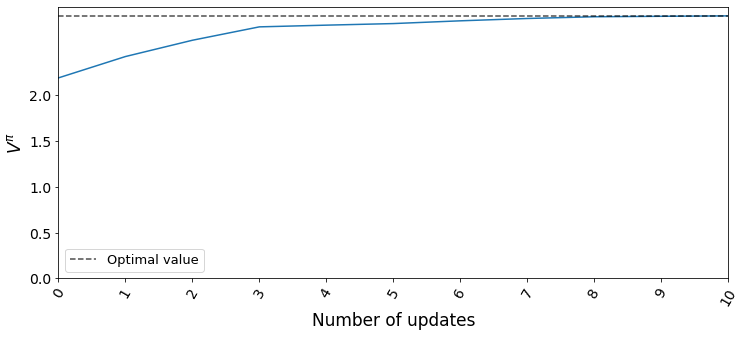

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(root_values)
plt.axhline(v_full, linestyle='--', color='k', alpha=0.7, label='Optimal value')
plt.ylabel(r'$V^{\pi}$', fontsize=17)
plt.xlabel('Number of updates', fontsize=17)
plt.xticks(range(len(root_values)), range(len(root_values)), fontsize=14, rotation=60)
plt.yticks([0, 0.5, 1, 1.5, 2], fontsize=14)

plt.xlim(0, len(qval_history)-1)
plt.ylim(0, v_full+0.1)
plt.legend(prop={'size':13})
# plt.savefig(os.path.join(save_path, 'root_values.svg'), transparent=True)

In [ ]:
root_values

In [ ]:
for idx, val in enumerate(np.diff(root_values)):
    print(idx+1, val)

In [ ]:
q0  = 1.5
q1s = np.linspace(0, q0, 151)

betas = [0.1, 0.5, 1, 4, 8]

plt.figure(figsize=(16, 7))
plt.subplot(121)

for beta in betas:
    tmp = []
    for q1 in q1s:
        qs   = np.array([q0, q1])
        tmp += [np.dot(policy(qs, temp=beta), qs)]
    plt.plot(tmp, label=r'$\beta=%.2f$'%beta)
plt.axhline(q0, c='k', label='Q-value for arm 1')
plt.legend()
plt.ylabel(r'$V^{\pi}$', fontsize=16)
plt.xlabel('Q-value for arm 2', fontsize=16)
plt.xticks(range(0, len(q1s), 10), [np.round(q1s[i], 2) for i in range(0, len(q1s), 10)], rotation=60)

plt.subplot(122)
q0  = 4
q1s = np.linspace(0, q0, 41)
for beta in betas:
    tmp = []
    for q1 in q1s:
        qs   = np.array([q0, q1])
        tmp += [np.dot(policy(qs, temp=beta), qs)]
    plt.plot(tmp, label=r'$\beta=%.2f$'%beta)
plt.axhline(q0, c='k', label='Q-value for arm 1')
plt.legend()
plt.ylabel(r'$V^{\pi}$', fontsize=16)
plt.xlabel('Q-value for arm 2', fontsize=16)
plt.xticks(range(0, len(q1s), 10), [np.round(q1s[i], 2) for i in range(0, len(q1s), 10)], rotation=60)

# save_path = '/home/georgy/Documents/Dayan_lab/PhD/bandits/bandit/data'
# plt.savefig(os.path.join(save_path, 'softmax.png'))